In [20]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

### Count of images in each set

Number of images in train folder: 12601
Number of images in test folder: 5410


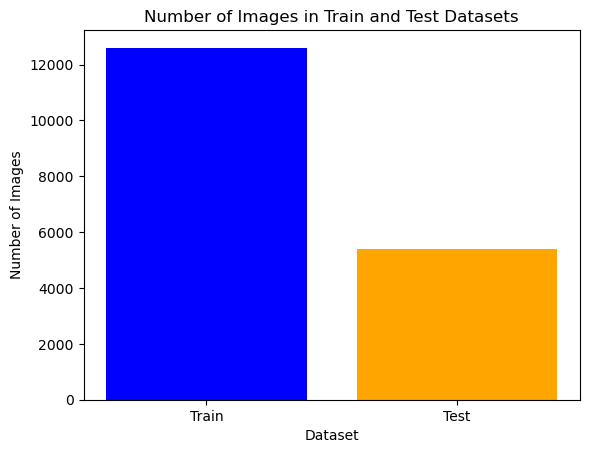

In [1]:

def count_images_in_folder(folder_path):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif')):
                count += 1
    return count

# Define the paths to the train and test folders
train_folder_path = 'Human Action Recognition/train'
test_folder_path = 'Human Action Recognition/test'

# Count the images in each folder
train_image_count = count_images_in_folder(train_folder_path)
test_image_count = count_images_in_folder(test_folder_path)

# Print the counts
print(f'Number of images in train folder: {train_image_count}')
print(f'Number of images in test folder: {test_image_count}')

# Plotting the bar graph
labels = ['Train', 'Test']
counts = [train_image_count, test_image_count]

plt.bar(labels, counts, color=['blue', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Number of Images in Train and Test Datasets')
plt.show()


### Copying the images and splitting based on class

In [2]:
# Configuration
csv_file_path = 'Human Action Recognition/Training_set.csv'  # Update with your CSV file path
base_directory = './Label-dataset/train'  # Update with your base directory path
images_directory = 'Human Action Recognition/train'  # Update with your images directory path

# Load the CSV file
df = pd.read_csv(csv_file_path)

# Get unique labels
labels = df['label'].unique()

# Create directories for each label
for label in labels:
    label_dir = os.path.join(base_directory, str(label))
    os.makedirs(label_dir, exist_ok=True)

# Copy files to corresponding directories with progress bar
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Copying files"):
    file_name = row['filename']
    label = row['label']
    
    # Define the source and destination paths
    src_path = os.path.join(images_directory, file_name)
    dst_path = os.path.join(base_directory, str(label), file_name)
    
    # Copy the file
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)
    else:
        print(f"File {src_path} does not exist.")


Copying files: 100%|████████████████████████████████████████████████████████████| 12600/12600 [01:22<00:00, 152.80it/s]


### Distribution of Classes in train dataset

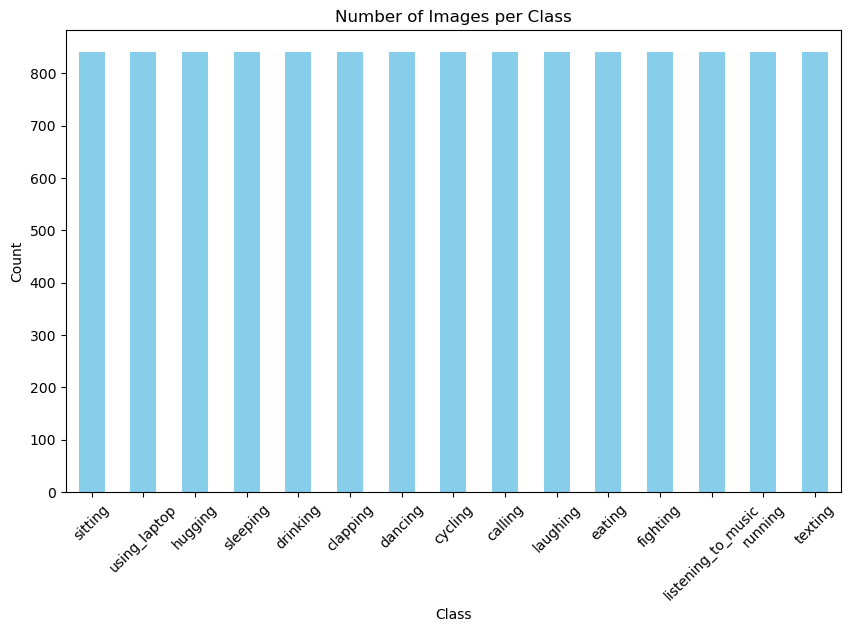

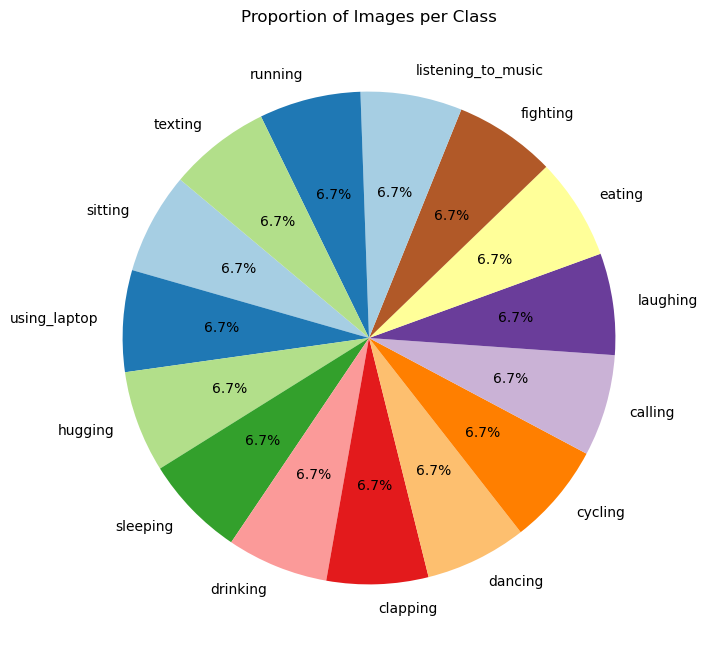

In [3]:
label_counts = df['label'].value_counts()

# Plot Bar Graph
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Plot Pie Chart
plt.figure(figsize=(8, 8))
label_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Proportion of Images per Class')
plt.ylabel('')  # Hides the 'y' label
plt.show()